In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import sqlite3
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split



In [3]:
# Load data into an SQLite database
conn = sqlite3.connect('crypto_data.db')

# Load CSV files into the database
crypto_files = {
    "Bitcoin": "Bitcoin_data.csv",
    "Dogecoin": "Dogecoin_data.csv",
    "Ethereum": "Ethereum_data.csv",
    "Litecoin": "Litecoin_data.csv",
    "SPY": "SPY_data.csv",
    "XRP": "XRP_data.csv"
}

for name, file in crypto_files.items():
    df = pd.read_csv(file)
    df.to_sql(name, conn, if_exists='replace', index=False)


In [4]:
# Query the data for Bitcoin
query = """
SELECT Date, PX_HIGH, PX_LOW, PX_LAST 
FROM Bitcoin
WHERE PX_HIGH IS NOT NULL AND PX_LOW IS NOT NULL AND PX_LAST IS NOT NULL;
"""
data = pd.read_sql(query, conn)

In [5]:
# Close the connection
conn.close()

In [6]:
# Sort data by most recent dates
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date', ascending=True)

In [7]:
# Data Cleaning and Normalization
data = data[['Date', 'PX_LAST']].dropna()
data.set_index('Date', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data['PX_LAST'] = scaler.fit_transform(data[['PX_LAST']])

In [8]:
# Prepare data for LSTM
look_back = 60
def create_dataset(dataset):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

values = data['PX_LAST'].values.reshape(-1, 1)
X, y = create_dataset(values)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [9]:
# Split into training and testing
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [10]:
#Build LTSM Model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=16), return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.05)))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=16), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.05)))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [11]:
#Build Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='bitcoin_lstm'
)
tuner.search(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 49s]
val_loss: 0.0008874306222423911

Best val_loss So Far: 0.000576200254727155
Total elapsed time: 00h 07m 16s


In [12]:
#Retrieve the Best Model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hyperparameters.values}")

Best Hyperparameters: {'units': 256, 'dropout_1': 0.35000000000000003, 'units_2': 240, 'dropout_2': 0.2}


In [13]:
#Train the Best Model
history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 7.6127e-04 - val_loss: 0.0021
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 4.6666e-04 - val_loss: 5.5880e-04
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 4.3503e-04 - val_loss: 9.8987e-04
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 4.3837e-04 - val_loss: 5.0315e-04
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 4.3728e-04 - val_loss: 6.3959e-04
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 4.3907e-04 - val_loss: 4.8013e-04
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 4.8733e-04 - val_loss: 4.9978e-04
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 4.5330e-04 - val_loss: 4.7887e-04
Epoch 10/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 5.5602e-04 - val_loss: 5.9547e-04
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 4.3617e-04 - val_

In [14]:
#Evaluate the Model
predicted = best_model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)

print(f"R^2 = {r2}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
R^2 = 0.9834128381309777


In [15]:
#Save Optimization Data
optimization_data = pd.DataFrame({
    'Epoch': range(1, len(history.history['loss']) + 1),
    'Training Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
})
optimization_data.to_csv('bitcoin_optimization_log.csv', index=False)


In [16]:
# Display results
print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")


RMSE: 2215.8270573913214
R^2 Score: 0.9834128381309777


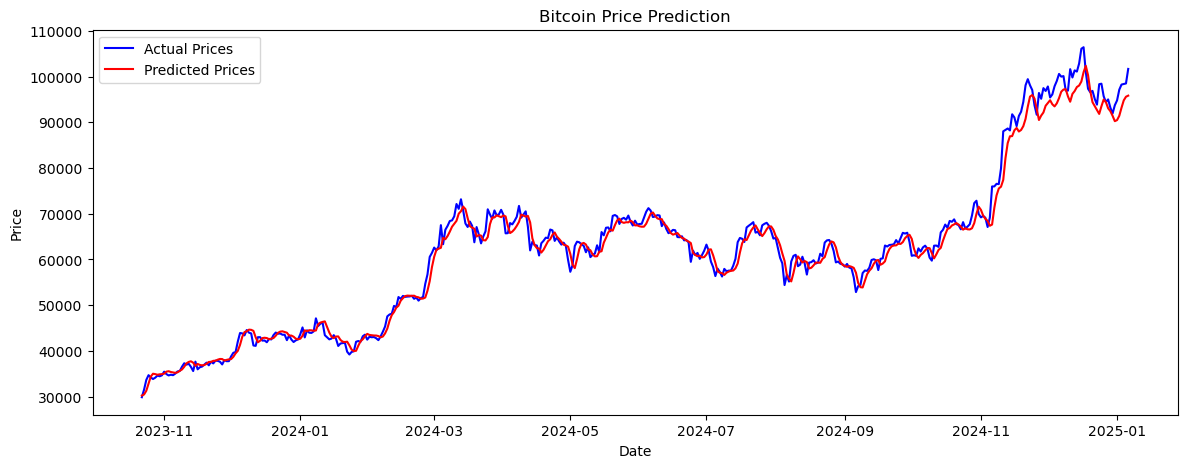

In [17]:
dates = data.index[-len(actual_prices):]
# Visualization
plt.figure(figsize=(14, 5))
plt.plot(dates, actual_prices, color='blue', label='Actual Prices')
plt.plot(dates, predicted_prices, color='red', label='Predicted Prices')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
# Function to predict future prices
def predict_future_prices(best_model, last_data, n_future):
    future_prices = []
    current_input = last_data

    for _ in range(n_future):
        # Reshape input to be [samples, time steps, features]
        current_input = np.reshape(current_input, (1, look_back, 1))
        # Predict the next price
        predicted_price = best_model.predict(current_input)
        # Store the predicted price
        future_prices.append(predicted_price[0][0])
        # Update the input for the next prediction
        current_input = np.append(current_input[0][1:], predicted_price).reshape(-1, 1)

    return future_prices

# Get the last 'look_back' prices from the training data
last_data = values[-look_back:]

# Forecast future prices (e.g., for the next year)
n_future = 360
future_prices = predict_future_prices(best_model, last_data, n_future)

# Inverse transform the predicted prices to get actual price values
future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

# Prepare dates for the future prices
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_future, freq='D')  # Use daily frequency

# Create a DataFrame for future prices
future_prices_df = pd.DataFrame(data=future_prices, index=future_dates, columns=['Predicted Price'])

# Display the future prices
print(future_prices_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

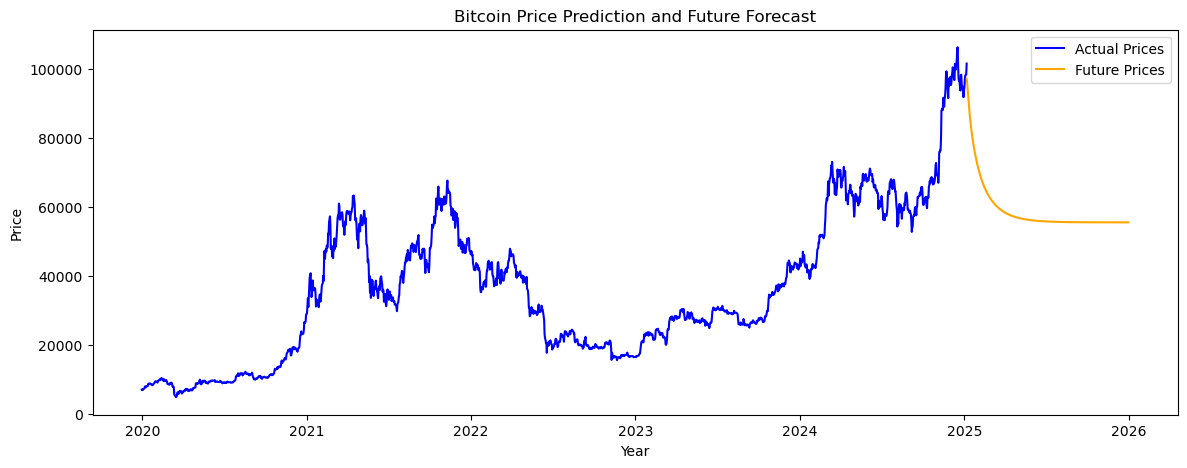

In [19]:
# Optionally, visualize the future prices along with the actual prices
plt.figure(figsize=(14, 5))
plt.plot(data.index, scaler.inverse_transform(values), color='blue', label='Actual Prices')
plt.plot(future_prices_df.index, future_prices_df['Predicted Price'], color='orange', label='Future Prices')
plt.title('Bitcoin Price Prediction and Future Forecast')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()